In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Explanation of weight matrix sizes

In [ ]:
''' Why weights come in matrices instead of vectors.
Know how to interpret the sizes of the weights matrices.
Cofirm weights sizes in PyTorch.

* Check out all those w's!
- There is one row in W for each unit in the layer. The same as the number of outputs of this layer.
- The number of elements in w is the number of inputs (x). This is the number of inputs to this layer.

'''

## Create a model and inspect its weight matrices sizes

In [ ]:
# build a model
aModel = nn.Sequential(
    nn.Linear(10,14),           # input layer
    nn.Linear(14,19),           # hidden layer
    nn.Linear(19,8),             # output layer
)

aModel

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=19, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [ ]:
# print the sizes of the weights matrices in each layer
for i in range(len(aModel)):
    print(aModel[i].weight.shape)

torch.Size([14, 10])
torch.Size([19, 14])
torch.Size([8, 19])


## Test model with fake data

In [ ]:
# generate data
nsamples = 5
nfeatures = 10

fakedata = torch.randn(nsamples, nfeatures)
fakedata.shape

torch.Size([5, 10])

In [ ]:
# test the model
aModel(fakedata).shape

torch.Size([5, 8])

# A surprising demo of weight initializations

In [ ]:
'''
* How to initialize the model's weight values to any arbitrary numbers.
* See what happens when weights are initialized to different values.

* The take-home message
- Models cannot learn when all trainable parameters are initialized to the same value.
- Models can learn as long as some trainable parameters are initialized to different numbers.
- Why is this?!?!!?

'''

## Import and process the data

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)

data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Explore the weights

In [ ]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)
print(tmpnet.fc1.weight.shape)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.0306,  0.0200,  0.0925,  ...,  0.0417, -0.0632, -0.1112],
        [ 0.1223, -0.1001,  0.0293,  ..., -0.0096,  0.0463,  0.0686],
        [-0.0267, -0.0165,  0.1102,  ...,  0.0770, -0.0011,  0.0545],
        ...,
        [-0.0619,  0.0488,  0.1023,  ...,  0.0411,  0.0529, -0.1143],
        [ 0.0636,  0.0312,  0.0581,  ..., -0.0756, -0.0781, -0.0344],
        [-0.0384, -0.0596, -0.1047,  ..., -0.1063, -0.1000, -0.0993]])
torch.Size([32, 64])


## Create a function that trains the model

In [ ]:
def function2trainTheModel(net, lossfunc, optimizer):

    numepochs = 10

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

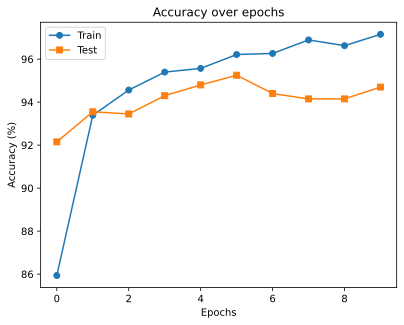

In [ ]:
# Run the model without changing the weights, this will be the baseline performance
# Notice the model creation is outside the function2train!!!

net_base, lossfunc, optimizer = createTheMNISTNet()
trainAcc_base, testAcc_base, losses, net_base = function2trainTheModel(net_base, lossfunc, optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)), trainAcc_base, 'o-', range(len(testAcc_base)), testAcc_base, 's-')
plt.legend(['Train', 'Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## Set all the weights of layer 1 to zero

In [ ]:
# Change the weights before training
net_zero, lossfunc, optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like(net_zero.fc1.weight)

# confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

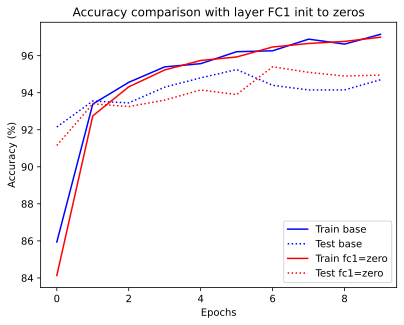

In [ ]:
# run the model and show the results
trainAcc_zero, testAcc_zero, losses, net_zero = function2trainTheModel(net_zero, lossfunc, optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1372,  0.2373, -0.6683,  ..., -0.0331,  0.0229,  0.0589],
        ...,
        [-0.1416, -0.8746, -0.5964,  ..., -0.5254,  0.4579,  0.0154],
        [-0.7420,  0.2119, -0.3427,  ...,  0.3199, -0.6826, -0.0492],
        [-1.1096,  0.1252, -0.0710,  ..., -0.4872,  0.3799,  0.0045]])


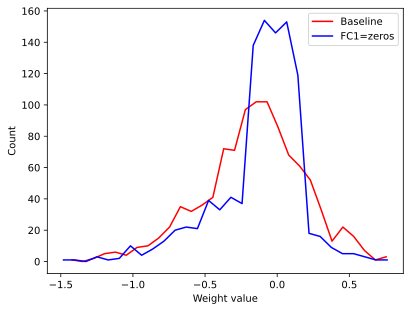

In [ ]:
# Are the weights still zero?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y, x = np.histogram(net_base.fc2.weight.data.flatten(), 30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y, x = np.histogram(net_zero.fc2.weight.data.flatten(), 30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

## Let's repeat the experiment with all learnable parameters set to zero

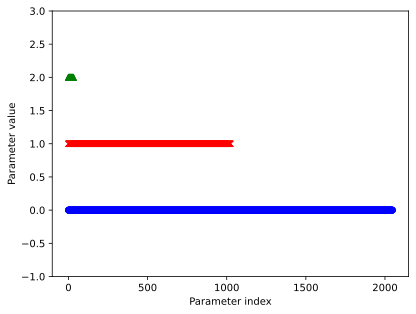

In [ ]:
# Change the weights before training
net_allzero, lossfunc, optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
    p[1].data = torch.zeros_like(p[1].data)

# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(), 'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(), 'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(), 'g^')
plt.xlabel('Parameter index')
plt.ylabel('Parameter value')
plt.ylim([-1,3])
plt.show()

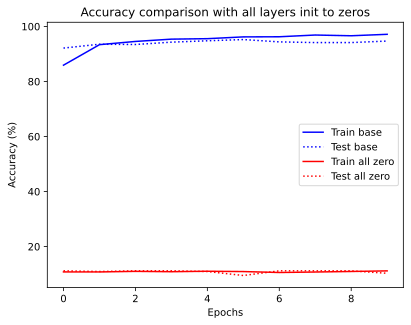

In [ ]:
# run the model and show the results
trainAcc_allzero, testAcc_allzero, _, net_allzero = function2trainTheModel(net_allzero, lossfunc, optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

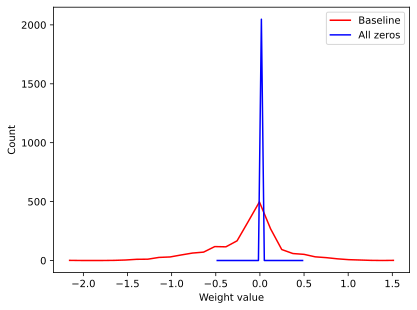

In [ ]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

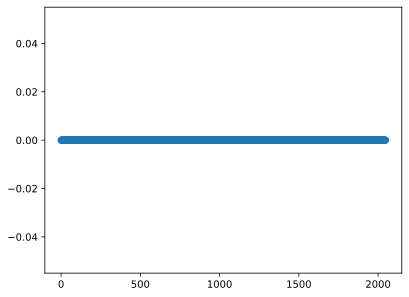

In [ ]:
# woah, not even a single non-zero weight value?!!???!?
plt.plot(net_allzero.fc1.weight.data.flatten(), 'o');

## Maybe zero is problematic. What about initializing to 1's?

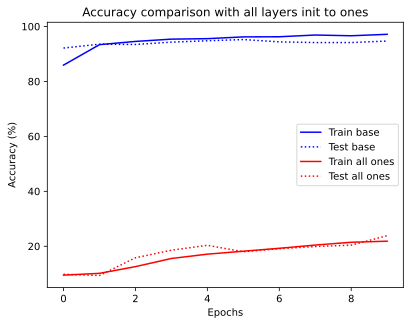

In [ ]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!


# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Theory: Why and how to initialize weights

In [ ]:
'''
* Why weights need to be randomized.
- Random initialization provides the necessary rough texture for g.d. to move.
- Random weights allow for any direction, even if it's (initially) the wrong one.
- From engineering: "Stochastic facilitation"

* Weight initialization: the algebraic view
- If all weights are the same, there is no diversity.
- With random weights, some will be strengthened, some weakened, some by a lot and some by a little.
- Equal weights is called "weight symmetry" and thus randomizing weights is "breaking symmetry."

* Best practices in weights initializations.
- So, how to initialize the weights?
- Random numbers drawn from a normal (Gaussian) distribution / a uniform (flat) distribution.
- With random weights, some will be strengthened, some weakened, some by a lot and some by a little.
- Standard deviation should be relatively small.

- Small weights (close to zero) increase risk of vanishing gradients.
- Large weights increase risk of exploding gradients.
- Solution: Set the variance of the weights proportional to the size of the network.
- Initializing biases is less important than weights.

* Common weights initializations
1) Kaiming: uniform distribution; std is proportional to input connections. based on activation slope. (*default in PyTorch)
2) Xavier: normal distribution; std is proportional to total input and output connections. (*Xavier can also have uniform distribution.)

'''

In [ ]:
''' Do weights initializations matter?
- For relatively simple models that are easy to train: No, not really. Just break symmetry and the model will be fine.
- For very large, complex models with billions (or more!) parameters, weight initialization can be important.
- Optimal weight initialization strategy is an active area of research in DL.

'''

# Weight variance inits

In [ ]:
''' Initialize the weights to be Gaussian random numbers, with standard deviations between .0001 and 10 in 25 logarithmic steps.
Create the histograms from all weights (across all layers). Use 80 bins for all histograms.
'''

## Import and process the data

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)

dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

## Creaet the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [ ]:
def function2trainTheModel(net, lossfunc, optimizer):

    numepochs = 10

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Start the experiment!

In [ ]:
# range of standard deviations to use
stdevs = np.logspace(np.log10(.0001), np.log10(10), 25)

# number of histogram bins for plotting distributions
nhistBins = 80

# initialize results output matrices
accresults = np.zeros(len(stdevs))
histodata = np.zeros((len(stdevs), 2, nhistBins))

# start the timer!
startTime = time.process_time()

# now to really start the experiment
for idx, std in enumerate(stdevs):

    # create the network
    net, lossfunc, optimizer = createTheMNISTNet()

    # set all parameters according to the standard deviation
    for p in net.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * std

    # train the model
    trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfunc, optimizer)

    # get test accuracy on final 3 runs (averaging increases stability)
    accresults[idx] = np.mean(testAcc[-3:])

    # collect all paramters into one vector and compute its histogram
    tmpparams = np.array([])
    for p in net.named_parameters():
        tmpparams = np.concatenate((tmpparams, p[1].data.numpy().flatten()), axis=0)

    # now compute their histogram
    y, x = np.histogram(tmpparams, nhistBins)
    histodata[idx, 0,:] = (x[1:]+ x[:-1])/2
    histodata[idx,1,:] = y

    # status report
    timeElapsed = time.process_time() - startTime
    print(f'Finished {idx+1} / {len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.2f}%.')

Finished 1 / 25 after  25s. Model accuracy was 92.57%.
Finished 2 / 25 after  51s. Model accuracy was 93.75%.
Finished 3 / 25 after  78s. Model accuracy was 91.70%.
Finished 4 / 25 after 100s. Model accuracy was 93.90%.
Finished 5 / 25 after 120s. Model accuracy was 93.00%.
Finished 6 / 25 after 142s. Model accuracy was 93.00%.
Finished 7 / 25 after 163s. Model accuracy was 93.53%.
Finished 8 / 25 after 183s. Model accuracy was 93.12%.
Finished 9 / 25 after 202s. Model accuracy was 93.97%.
Finished 10 / 25 after 222s. Model accuracy was 93.17%.
Finished 11 / 25 after 241s. Model accuracy was 93.37%.
Finished 12 / 25 after 258s. Model accuracy was 94.70%.
Finished 13 / 25 after 277s. Model accuracy was 94.20%.
Finished 14 / 25 after 295s. Model accuracy was 94.75%.
Finished 15 / 25 after 312s. Model accuracy was 94.47%.
Finished 16 / 25 after 330s. Model accuracy was 93.97%.
Finished 17 / 25 after 347s. Model accuracy was 93.95%.
Finished 18 / 25 after 364s. Model accuracy was 93.35%.
F

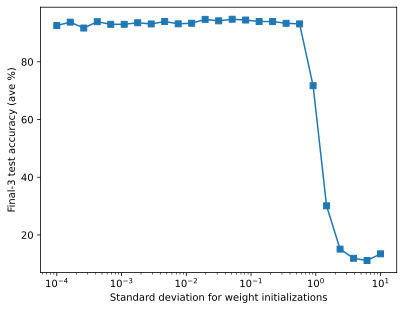

In [ ]:
# Show the results!
plt.plot(stdevs, accresults, 's-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
# plt.ylim([80,100])
plt.show()

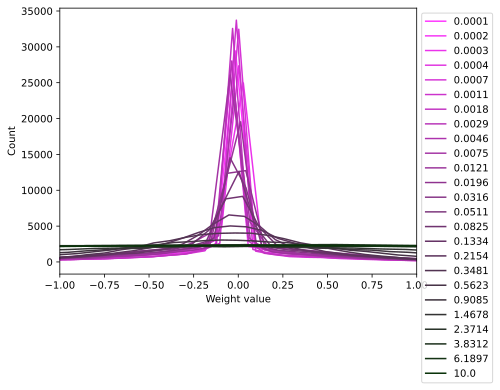

In [ ]:
# show the weights distributions

for i in range(len(stdevs)):
    plt.plot(histodata[i,0,:], histodata[i,1,:], color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4), bbox_to_anchor=(1,1), loc='upper left')
plt.xlim([-1,1])
plt.show()

# Xavier and Kaiming intializations

In [ ]:
'''
* How to implement the two most common weight initialization methods.
* More about how to access, modify, and explore the weights and biases tensors.
'''

## Create the DL model

In [ ]:
# create a class for the model
class thenet(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(100,100)

        # hidden layer
        self.fc1 = nn.Linear(100,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,100)

        # output layer
        self.output = nn.Linear(100,2)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.output(x)

## Explore the initialized weights

In [ ]:
# create an instance of the model
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if 'bias' in p[0]:
        allbiases = np.concatenate( (allbiases, p[1].data.numpy().flatten()), axis=0 )
    elif 'weight' in p[0]:
        allweight = np.concatenate( (allweight, p[1].data.numpy().flatten()), axis=0 )

# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight paramters.')

There are 402 bias parameters.
There are 40200 weight paramters.


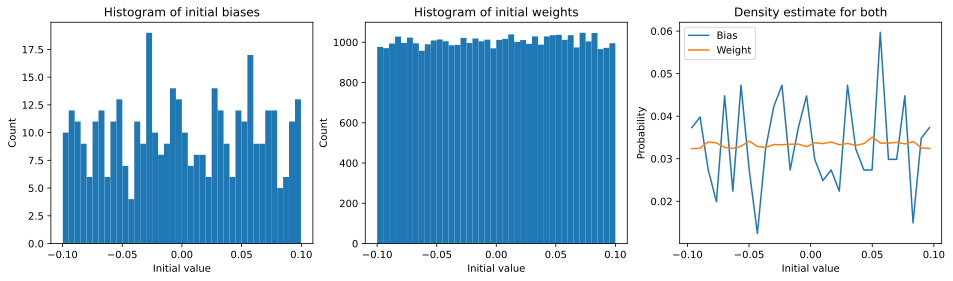

In [ ]:
# show their histograms
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(allbiases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(allweight, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()

# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

## Layer-specific distributions

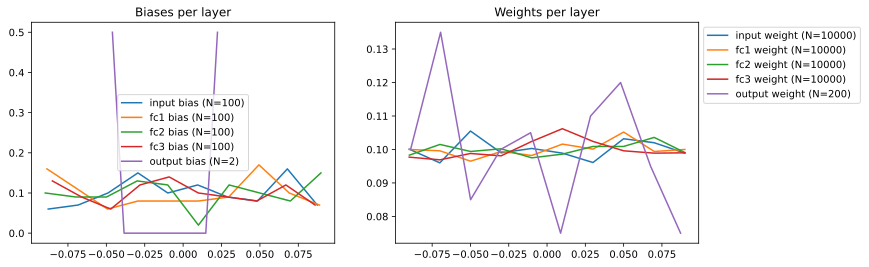

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [ ]:
# What's up with the weird output bias distribution??
print( net.output.bias.data )

tensor([ 0.0262, -0.0499])


In [ ]:
# Check out the docstring for linear layers
nn.Linear?

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical bias range
biasrange = [ torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item() ]
biascount = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/biascount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma))
print('Empirical range = ' + str(biasrange))


Theoretical sigma = 0.1
Empirical range = [-0.09853098541498184, 0.09866616874933243]


## Now to initialize the weights using the Xavier method

In [ ]:
# create a new instance of the model
net = thenet()

# change the weights (leave biases as Kaiming [default])
for p in net.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

# Note: it is unconventional to have Kaiming biases and Xavier weights.
# Scroll up and re-run the previous weights visualization cells with the new network.
# Then continue below.

In [ ]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if 'bias' in p[0]:
        allbiases = np.concatenate( (allbiases, p[1].data.numpy().flatten()), axis=0 )
    elif 'weight' in p[0]:
        allweight = np.concatenate( (allweight, p[1].data.numpy().flatten()), axis=0 )

# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight paramters.')

There are 402 bias parameters.
There are 40200 weight paramters.


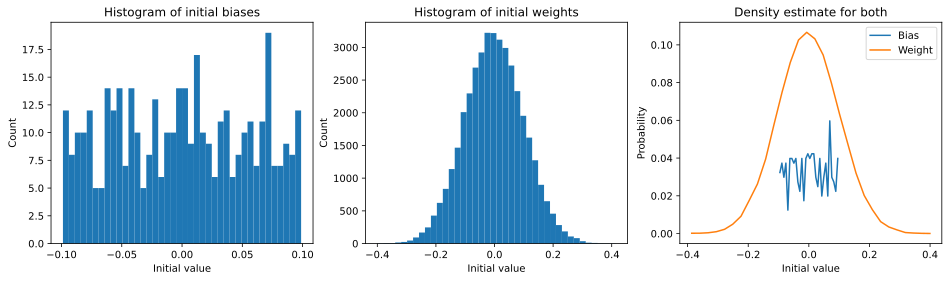

In [ ]:
# show their histograms
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(allbiases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(allweight, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()

# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

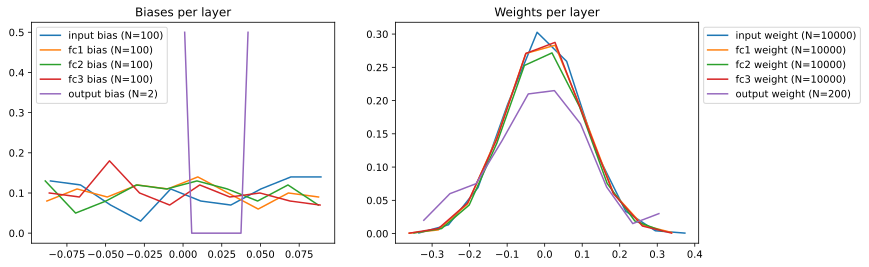

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical weight standard deviation
weightvar   = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# theoretical expected value
sigma2 = 2 / (weightcount+weightcount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma2))
print('Empirical variance = ' + str(weightvar))

Theoretical sigma = 0.01
Empirical variance = 0.01017744280397892


In [ ]:
# Note: There are several other weights initialization methods availabe in PyTorch.
#       See https://pytorch.org/docs/stable/nn.init.html

# Xavier vs. Kaiming

In [ ]:
'''
Model wine quality using Xavier vs. Kaiming initialization on the weights (use default initialization for the biases).
Run both models 10x each, visualize the performance, and run a t-test to compare.
'''

## Import and process the data

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

<ipython-input-31-e31aebccf04d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [ ]:
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Now for the DL part

In [ ]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)
        self.output = nn.Linear(32,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

## A function to train the model

In [ ]:
numepochs = 600

def trainTheModel(winenet):

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        winenet.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    return trainAcc, testAcc, losses

## Experiment: initialize weights and test model!

In [ ]:
# create a model
winenet_xavier = ANNwine()

# change the weights (leave biases as Kaiming [default])
for p in winenet_xavier.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

# train the model and record its output
trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)

In [ ]:
# create and train a model
winenet_kaiming = ANNwine()

# change the weights (leave biases as Kaiming [default])
for p in winenet_kaiming.named_parameters():
    if 'weight' in p[0]:
        nn.init.kaiming_uniform_(p[1].data, nonlinearity='relu')

# train the model and record its output
trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)

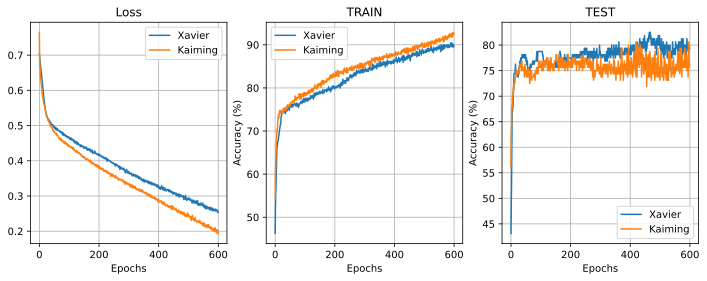

In [ ]:
# plot the results
fig, ax = plt.subplots(1,3,figsize=(12,4))

# losses
ax[0].plot(losses_X, label='Xavier')
ax[0].plot(losses_K, label='Kaiming')
ax[0].set_title('Loss')

# train accuracy
ax[1].plot(trainAcc_X, label='Xavier')
ax[1].plot(trainAcc_K, label='Kaiming')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('TRAIN')

# test accuracy
ax[2].plot(testAcc_X, label='Xavier')
ax[2].plot(testAcc_K, label='Kaiming')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('TEST')

for i in range(3):
    ax[i].legend()
    ax[i].grid('on')
    ax[i].set_xlabel('Epochs')

plt.show()

## Repeat the experiment to get more stable results

In [ ]:
# Number of experiment iterations (note: ~ 1 min/iteration)
numExps = 10

# dimensions of results:
#  1 - experiment run
#  2 - metric (loss/train/test)
#  3 - weight init (X/K)
results = np.zeros((numExps, 3, 2))

for expi in range(numExps):

    #### XAVIER
    # create a model and change the weights
    winenet_xavier = ANNwine()
    for p in winenet_xavier.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)

    # train the model and record its output
    trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)

    #### KAIMING
    # create a model and change the weights
    winenet_kaiming = ANNwine()
    for p in winenet_kaiming.named_parameters():
        if 'weight' in p[0]:
            nn.init.kaiming_uniform_(p[1].data, nonlinearity='relu')

    # train the model and record its output
    trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)

    #### collect the results!
    results[expi, 0, 0] = torch.mean(losses_X[-5:]).item()
    results[expi, 0, 1] = torch.mean(losses_K[-5:]).item()

    results[expi, 1, 0] = np.mean(trainAcc_X[-5:])
    results[expi, 1, 1] = np.mean(trainAcc_K[-5:])

    results[expi, 2, 0] = np.mean(testAcc_X[-5:])
    results[expi, 2, 1] = np.mean(testAcc_K[-5:])

    # a little update message...
    print(f'Finished run {expi} / {numExps}')

Finished run 0 / 10
Finished run 1 / 10
Finished run 2 / 10
Finished run 3 / 10
Finished run 4 / 10
Finished run 5 / 10
Finished run 6 / 10
Finished run 7 / 10
Finished run 8 / 10
Finished run 9 / 10


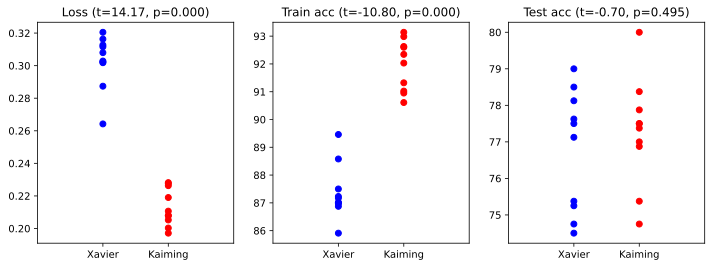

In [ ]:
# And plot the results
fig, ax = plt.subplots(1,3,figsize=(12,4))

# plot titles
metric = ['Loss', 'Train acc', 'Test acc']

for i in range(3):

    # plot the results
    ax[i].plot(np.zeros(numExps), results[:,i,0], 'bo')
    ax[i].plot(np.ones(numExps), results[:,i,1], 'ro')

    # run a t-test to formalize the comparison
    t, p = stats.ttest_ind(results[:,i,0], results[:,i,1])
    title = '%s (t=%.2f, p=%.3f)' %(metric[i], t, p)

    # make the plot look a bit nicer
    ax[i].set_xlim([-1,2])
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['Xavier', 'Kaiming'])
    ax[i].set_title(title)

plt.show()

In [ ]:
# 1) Adam usually works better than SGD with fewer training epochs. Does Adam also equalize the differences attributable
#    to weight initialization?
#
# 2) The discrepancy between training and test performance suggests that Kaiming initialization involved some overfitting.
#    What are some strategies you could employ to reduce overfitting?
#
# 3) The difference between X and K initialization is likely to increase with more weights. Change the number of units in
#    the hidden layers from 32 to 64.

# Identically random weights

In [ ]:
'''
How to use pytorch's random seed to create reproducible random networks.

Create a network with 2 input, 8 hidden units, and 1 output.
Make four copies of the network, apply Xavier weight inits.
- net_noseed: No random seed.
- net_rs1a: Random seed 1.
- net_rs2: Random seed 2.
- net_rs1b: Random seed 1.

* When to use random seeds
- Obviously, when you want to reproduce (yourself or someone else) a DL result exactly.
- Make sure you are testing unique models, not the same model repeatedly!
- How to use seeds: explore unique networks, then fix the rng to share (if it's important).
- Seeding is unnecessary when exporting trained models.

'''

In [ ]:
# create a model
net = nn.Sequential(
    nn.Linear(2,8),
    nn.Linear(8,1),
    nn.Linear(1,1),
)

## Create the four networks

In [ ]:
### NO RANDOM SEED

# create a "template" network
net_noseed = copy.deepcopy(net)

# update the weights
for p in net_noseed.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [ ]:
### RANDOM SEED 1a

# create a "template" network
net_rs1a = copy.deepcopy(net)

# set the seed to 1
torch.manual_seed(1)

# update the weights
for p in net_rs1a.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [ ]:
### RANDOM SEED 2

# create a "template" network
net_rs2 = copy.deepcopy(net)

# set the seed to 2
torch.manual_seed(2)

# update the weights
for p in net_rs2.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [ ]:
### RANDOM SEED 1b

# create a "template" network
net_rs1b = copy.deepcopy(net)

# set the seed to 1
torch.manual_seed(1)

# update the weights
for p in net_rs1b.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

## Extract all weights from all networks

In [ ]:
# initialize empty arrays
w_ns = np.array([])
w_1a = np.array([])
w_2 = np.array([])
w_1b = np.array([])

# loop over layers in the models
for i in range(3):

    # extract the vectorized weights matrices
    w_ns = np.append(w_ns, net_noseed[i].weight.view(-1).detach().numpy())
    w_1a = np.append(w_1a, net_rs1a[i].weight.view(-1).detach().numpy())
    w_2 = np.append(w_2, net_rs2[i].weight.view(-1).detach().numpy())
    w_1b = np.append(w_1b, net_rs1b[i].weight.view(-1).detach().numpy())

# check the vector
w_ns

array([ 0.45754081,  0.26633638,  0.55969721,  0.10050529, -0.39591709,
       -0.17284694,  0.4410001 , -0.15273002, -0.2656188 ,  0.47447464,
        0.22312394,  0.69193405, -0.5829578 , -0.23839608,  0.02404713,
       -0.41175702, -0.47691581, -0.20232439, -0.16838893, -0.08601875,
        0.11332134,  0.44660038,  0.44782975,  0.30023015,  1.57051611])

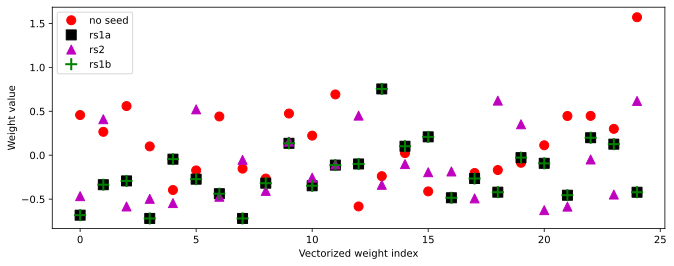

In [ ]:
# plotting
fig = plt.figure(figsize=(11,4))

plt.plot(w_ns, 'ro', markersize=9, label='no seed')
plt.plot(w_1a, 'ks', markersize=10, label='rs1a')
plt.plot(w_2, 'm^', markersize=9, label='rs2')
plt.plot(w_1b, 'g+', markersize=12, label='rs1b', markeredgewidth=2)
plt.legend()
plt.xlabel('Vectorized weight index')
plt.ylabel('Weight value')

plt.show()

In [ ]:
# the algebraic test

print('1a-1b should be zeros:')
print(w_1a - w_1b)
print('\n\n')

print('1a-2 should be non-zeros:')
print(w_1a - w_2)
print('\n\n')

print('1a-ns should be non-zeros:')
print(w_1a- w_ns)

1a-1b should be zeros:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]



1a-2 should be non-zeros:
[-0.21680683 -0.74543169  0.29078251 -0.22352022  0.50025801 -0.79460078
  0.03471264 -0.66646316  0.08751756 -0.01855947 -0.09211725 -0.0073103
 -0.55001713  1.09119886  0.20277754  0.40263602 -0.29967313  0.22609788
 -1.04223195 -0.37989978  0.53314489  0.12994796  0.2475912   0.57373706
 -1.03930008]



1a-ns should be non-zeros:
[-1.13980806 -0.60185024 -0.85216635 -0.82028878  0.35112096 -0.09959063
 -0.87916759 -0.56687972 -0.05286196 -0.33864604 -0.57074946 -0.80438825
  0.48355542  0.99289611  0.07810772  0.62088998 -0.00750351 -0.06310123
 -0.25224084  0.05855935 -0.20548544 -0.90180552 -0.24870126 -0.1742157
 -1.99171126]


# Freezing weights during learning

In [ ]:
'''
- "Freezing" a leyer means to switch off gradient descent in that layer.
- This means that the weights will not change, and thus the layer will no longer learn.
- Think of the parameter requires_grad as a toggle that switches on (True) or off (False) learning in for that weight matrix (or bias).

* Why would you want to switch off learning?
- The main application is when working with downloaded (pretrained) networks.
- The network is already trained, but you need to fine-tune it for your specific dataset.
- This is called "tansfer learning".
'''

## Import and process the data

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)

data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [5]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()

    # using SGD to slow down learning! (look at the effect of "freezing weight")
    optimizer = torch.optim.SGD(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

## Brief inspection of requires_grad

In [4]:
# inspect the "learning togle" of a layer
N = createTheMNISTNet()[0]
N.fc1.weight.requires_grad

True

In [6]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
    if 'input' not in p[0]:
        p[1].requires_grad = False

# check what we've done
for p in N.named_parameters():
    print('Requires_grad status in layer %s: %s' %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


## Create a function that trains the model

In [8]:
def function2trainTheModel(net, lossfunc, optimizer):

    numepochs = 100

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        # NEW!!: switch off learning in all-but-output layers during first 1/2 of training
        if epochi < (numepochs/2):
            for p in net.named_parameters():
                # "freezing" except for output layer
                if 'output' not in p[0]:
                    p[1].requires_grad = False
        else:
            for p in net.named_parameters():
                p[1].requires_grad = True

        # loop over training batches
        net.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Let's see it in action!

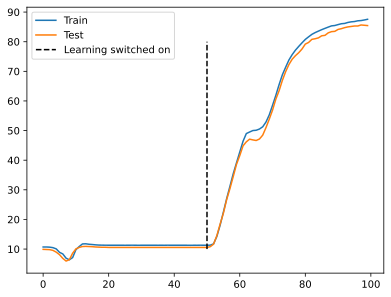

In [9]:
# create the network
net, lossfunc, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfunc, optimizer)

plt.plot(trainAcc, label='Train')
plt.plot(testAcc, label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2], [10,80], 'k--', label='Learning switched on')
plt.legend()
plt.show()

# Learning-related changes in weights

In [ ]:
''' Changes in weights matrices over time
- Obviously, the weights change over time (that's the whole point!)
- How to quantify those changes?
- Previously, Shape and width of distribution (histograms)
- General changes over all weights per layer.

* Metric 1: Euclidean distance
- Subtract two matrices, square each element, sum the entire matrix, take the square root.
- Larger distances mean the weights are changing rapidly (a lot of learning).
  Small distances (close to zero) mean the weights change very little (little learning).

* Metric 2: Condition number
- Compute the SVD, take the ratio of largest to smallest singular values.
- Larger condition numbers indicate sparser matrices, meaning some directions are spacious while others are thin.
  It means the network learned specific features.
  Large condition numbers indicate sparse representations, or possible overfitting.

'''

## Create a function that trains the model

In [11]:
def function2trainTheModel(net, lossfunc, optimizer):

    numepochs = 60

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # initialize weight change matrices
    weightChange = np.zeros((numepochs, 4))
    weightConds = np.zeros((numepochs, 4))

    # loop over epochs
    for epochi in range(numepochs):

        # store the weights for each layer
        preW = []
        for p in net.named_parameters():
            if 'weight' in p[0]:
                preW.append( copy.deepcopy(p[1].data.numpy()) )

        # loop over training batches
        net.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        # finally, get the post-learning state of the weights
        for (i, p) in enumerate(net.named_parameters()):
            if 'weight' in p[0]:
                # condition number
                weightConds[epochi, int(i/2)] = np.linalg.cond(p[1].data)

                # Frobenius norm of the weight change from pre-learning
                weightChange[epochi, int(i/2)] = np.linalg.norm( preW[int(i/2)] - p[1].data.numpy(), ord='fro' )

    # end epochs

    return trainAcc, testAcc, losses, net, weightChange, weightConds, preW

## Run the model and plot the results

In [12]:
# create the network
net, lossfunc, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net, weightChange, weightConds, preW = function2trainTheModel(net, lossfunc, optimizer)

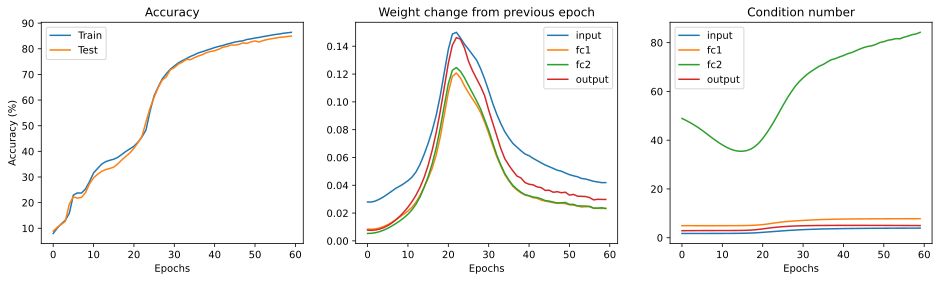

In [18]:
# Show the results!

# get a list of layer names
layername = []
for (i, p) in enumerate(net.named_parameters()):
    if 'weight' in p[0]:
        layername.append(p[0][:-7])

# set up the plot
fig, ax = plt.subplots(1,3,figsize=(16,4))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
# ax[2].set_ylim([0,20])

plt.show()

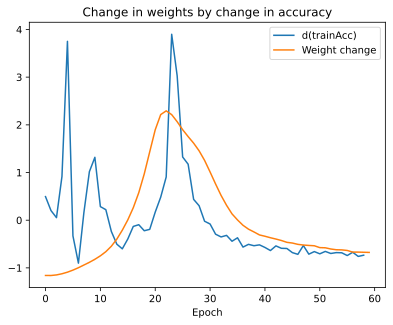

In [20]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore

plt.plot(zscore(np.diff(trainAcc)), label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange, axis=1)), label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()

# Use default inits or apply your own?

In [ ]:
'''
- Relatively small networks or relatively simple problems will likely find good solutions,
  regardless of the weights initializations.
- For larger, deeper networks (e.g., CNNs) or difficult problems, weight initializations can be impactful.
- PyTorch defaults may not reflect current best-practices.
- For testing or development purposes.

'''